In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1013. Microbiome Peanut Allergy/P1013.3. Analyses/P1013.4. Outcome Prediction/Output')
cur_date = "092025"

library(readxl)
library(tidyverse)
library(gtsummary)
library(caret)
library(e1071)
library(Hmisc)
library(randomForest)
library(pROC)
library(themis)

# reading in files
saliva_df = data.frame(read_excel("Input/Processed_Saliva_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE)) 
stool_df = data.frame(read_excel("Input/Processed_Stool_Data_090525.xlsx")) %>%
    mutate(Age = as.numeric(Age), IgE = as.numeric(IgE)) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘Hmisc’


The following object is masked from ‘package:e1071’:

    impute


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching packa

In [2]:
head(saliva_df)

,Original_Sample_ID,Subject_No,Sample_ID,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FS01baseline,1,Pre_1,Pre,P,F,3.838356,41.00,High,7,⋯,57,13,0,213,775,0,14,246,44,64
2,FS0236mo,2,Post_2,Post,A,DS,1.873973,14.20,Low,63,⋯,698,0,43,98,1657,0,0,423,146,123
3,FS02baseline,2,Pre_2,Pre,A,DS,1.873973,14.20,Low,0,⋯,0,0,46,371,3359,0,0,0,0,112
4,FS0436mo,3,Post_3,Post,P,F,3.715068,67.40,High,34,⋯,0,0,0,0,92,0,200,67,32,201
5,FS04baseline,3,Pre_3,Pre,P,F,3.715068,67.40,High,4,⋯,0,0,0,0,43,414,47,0,2,1050
6,FS0536mo,4,Post_4,Post,A,DS,3.991781,9.59,Low,6,⋯,0,17,0,139,2521,0,0,502,39,101


In [3]:
`%notin%` <- Negate(`%in%`)

paired_saliva_df = saliva_df  %>%
    # removing those failed the IgE protein
    filter(IgE_Binarized != 'Fail')  %>%
    # ended up reassinging 'DS' to 'F' due to small sample size
      mutate(Outcome = relevel(factor(ifelse(Outcome %in% 'SU', 1, 0)), ref = "0"),
           IgE_Binarized = relevel(factor(ifelse(IgE_Binarized == 'Low', 0, 1)), ref = "0")) %>%
    # removing 13 participants that don't have pre and post samples
    filter(Subject_No %notin% c(1,12,13,16,17,20,24,26,31,32,36,37,43),
    # retaining those given treatment
          Treatment == 'A') %>%
    # normalizing
    mutate(across(10:ncol(saliva_df), ~ log(.x + 2))) 

paired_stool_df = stool_df  %>%
    filter(IgE_Binarized != 'Fail') %>%
     mutate(Outcome = relevel(factor(ifelse(Outcome %in% 'SU', 1, 0)), ref = "0"),
           IgE_Binarized = relevel(factor(ifelse(IgE_Binarized == 'Low', 0, 1)), ref = "0")) %>%
     # removing 10 participants that don't have pre and post samples
    filter(Subject_No %notin% c(3,10,14,15,23,25,27,32,35,39),
          Treatment == 'A') %>%
    mutate(across(11:ncol(stool_df), ~ log(.x + 2)))

head(paired_saliva_df)

,Original_Sample_ID,Subject_No,Sample_ID,Time_Point,Treatment,Outcome,Age,IgE,IgE_Binarized,k__Bacteria.__.__.__.__.__.__,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<chr>,<dbl>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,FS0236mo,2,Post_2,Post,A,0,1.873973,14.20,0,4.1743873,⋯,6.5510803,0.6931472,3.8066625,4.605170,7.413970,0.6931472,0.6931472,6.0520892,4.9972123,4.828314
2,FS02baseline,2,Pre_2,Pre,A,0,1.873973,14.20,0,0.6931472,⋯,0.6931472,0.6931472,3.8712010,5.921578,8.119994,0.6931472,0.6931472,0.6931472,0.6931472,4.736198
3,FS0536mo,4,Post_4,Post,A,0,3.991781,9.59,0,2.0794415,⋯,0.6931472,2.9444390,0.6931472,4.948760,7.833204,0.6931472,0.6931472,6.2225763,3.7135721,4.634729
4,FS05baseline,4,Pre_4,Pre,A,0,3.991781,9.59,0,3.2580965,⋯,0.6931472,0.6931472,0.6931472,4.718499,7.112327,3.7376696,1.7917595,6.0038871,3.6109179,5.129899
5,FS0736mo,6,Post_6,Post,A,1,1.419178,1.32,0,1.3862944,⋯,0.6931472,0.6931472,0.6931472,6.142037,7.407318,2.1972246,0.6931472,5.1298987,4.1431347,6.084499
6,FS07baseline,6,Pre_6,Pre,A,1,1.419178,1.32,0,2.1972246,⋯,0.6931472,0.6931472,0.6931472,7.748029,7.590852,0.6931472,2.8903718,0.6931472,1.9459101,3.401197


In [14]:
# getting FC
log_saliva_df = lag(paired_saliva_df[,10:ncol(saliva_df)])/paired_saliva_df[,10:ncol(saliva_df)]
log_saliva_df = log_saliva_df[seq_len(nrow(log_saliva_df)) %% 2 == 0, ]
combined_saliva_df = cbind(paired_saliva_df[,c(2,6:8)] %>%
                               unique() %>% 
                               remove_rownames %>%
                               column_to_rownames('Subject_No'), log_saliva_df)

log_stool_df = lag(paired_stool_df[,11:ncol(stool_df)])/paired_stool_df[,11:ncol(stool_df)]
log_stool_df = log_stool_df[seq_len(nrow(log_stool_df)) %% 2 == 0, ]
combined_stool_df = cbind(paired_stool_df[,c(3,7:9)] %>%
                               unique() %>% 
                               remove_rownames %>%
                               column_to_rownames('Subject_No'), log_stool_df)

head(combined_saliva_df)

,Outcome,Age,IgE,k__Bacteria.__.__.__.__.__.__,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_874,k__Bacteria.p__Absconditabacteria_.SR1..c__Absconditabacteria_.SR1._.C.1..o__Absconditabacteria_.SR1._.O.1..f__Absconditabacteria_.SR1._.F.1..g__Absconditabacteria_.SR1._.G.1..s__bacterium_HMT_875,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.__,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Actinomyces.s__graevenitzii,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Schaalia.s__lingnae,k__Bacteria.p__Actinobacteria.c__Actinomycetia.o__Actinomycetales.f__Actinomycetaceae.g__Schaalia.s__sp._HMT_180,⋯,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.__.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Aggregatibacter.s__aphrophilus,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.s__parainfluenzae,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..__,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_347,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.1..s__bacterium_HMT_352,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.3..s__bacterium_HMT_351,k__Bacteria.p__Saccharibacteria_.TM7..c__Saccharibacteria_.TM7._.C.1..o__Saccharibacteria_.TM7._.O.1..f__Saccharibacteria_.TM7._.F.1..g__Saccharibacteria_.TM7._.G.6..s__bacterium_HMT_870
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,0,1.873973,14.20,6.0223678,1.140281,8.647458,1.0888268,1.2622362,1.3470711,1.3171805,⋯,9.451211,1.000000,0.9833286,0.7776930,0.9130512,1.000000,1.0000000,8.7313190,7.209453,1.0194492
4,0,3.991781,9.59,0.6382382,1.000000,1.623249,0.7974088,1.1740045,0.1714416,0.8787072,⋯,1.000000,4.247928,1.0000000,1.0487996,1.1013559,0.185449,0.3868528,1.0364246,1.028429,0.9034738
6,1,1.419178,1.32,0.6309298,4.700440,1.000000,1.0305566,1.5563025,4.5235620,1.5128480,⋯,1.000000,1.000000,1.0000000,0.7927226,0.9758216,3.169925,0.2398125,7.4008794,2.129150,1.7889286
9,1,1.389041,0.42,1.1005724,1.000000,1.000000,1.4281986,8.0056245,6.0443941,1.3956664,⋯,1.000000,1.000000,1.0000000,0.5133670,0.9129980,2.584963,1.0000000,8.9158794,4.643856,2.7702106
11,0,1.567123,4.34,1.4771213,3.807355,1.000000,1.5424305,2.0714662,1.0162105,1.1574001,⋯,1.000000,1.000000,1.0000000,2.2108715,1.0270003,1.000000,1.0000000,1.7658363,1.952672,1.5892510
14,0,3.912329,105.00,1.9534453,1.000000,1.000000,0.9052225,0.8867124,0.1433223,0.8634340,⋯,1.755875,1.000000,1.0000000,1.8356838,1.4479534,1.000000,1.0000000,0.8403361,1.244094,0.1707073


# Random Forest

In [5]:
rf_classification = function(dataset, outcome, pred_outcome, knn){
    # setting for reproducibility
    set.seed(12)
    # splitting data into training and testing sets
    dataset_index = createFolds(dataset[[outcome]], k = 5) # 5 fold CV
    
    ntree_values = c(50, 250, 500) # number of trees 
    p = dim(dataset)[2] - 1 # number of variables in dataset
    mtry_values = c(sqrt(p), p/2, p/3) # number of predictors

    metrics = data.frame()
    variable_importance_df = data.frame()
    roc_objects = c()
    threshold_data = data.frame()
    
    for (i in 1:length(dataset_index)){
        
        data_train = dataset[-dataset_index[[i]],]
        # using SMOTE to balance the class distribution
        balanced_data_train = smotenc(data_train, outcome, k = knn)
        data_test = dataset[dataset_index[[i]],]

        # will use ntree and mtry values to determine which combination yields the smallest MSE
        reg_rf_pred_tune = list()
        rf_OOB_errors = list()
        rf_error_df = data.frame()
        for (j in 1:length(ntree_values)){
            for (k in 1:length(mtry_values)){
                reg_rf_pred_tune[[k]] = randomForest(as.formula(paste0(outcome, "~.")), data = balanced_data_train, 
                                                     ntree = ntree_values[j], mtry = mtry_values[k])
                rf_OOB_errors[[k]] = data.frame("Tree Number" = ntree_values[j], "Variable Number" = mtry_values[k], 
                                       "OOB_errors" = reg_rf_pred_tune[[k]]$err.rate[ntree_values[j],1])
                rf_error_df = rbind(rf_error_df, rf_OOB_errors[[k]])
            }
        }

        # finding the lowest OOB error using best number of predictors at split and refitting OG tree
        best_oob_errors = which(rf_error_df$OOB_errors == min(rf_error_df$OOB_errors))

        reg_rf = randomForest(as.formula(paste0(outcome, "~.")), data = balanced_data_train,
                               ntree = rf_error_df$Tree.Number[min(best_oob_errors)],
                               mtry = rf_error_df$Variable.Number[min(best_oob_errors)])

        # predicting on test set
        data_test[[pred_outcome]] = predict(reg_rf, newdata = data_test, type = "response")
        
        matrix = confusionMatrix(data = data_test[[pred_outcome]], reference = data_test[[outcome]], 
                                     positive = "1")

        # calculating AUC
        auc = auc(response = data_test[[outcome]], predictor = factor(data_test[[pred_outcome]], ordered = TRUE))
        
        # calculating values to plot ROC curve later
        roc_obj = roc(response = data_test[[outcome]], predictor = factor(data_test[[pred_outcome]], ordered = TRUE))

        # Return max Youden's index, with specificity and sensitivity
        best_thres_data = data.frame(coords(roc_obj, x = "best", best.method = c("youden", "closest.topleft")))
        threshold_data = rbind(threshold_data, best_thres_data)
        
        #extracting accuracy, sens, spec, PPV, NPV to take mean later
        matrix_values = data.frame(t(c(matrix$byClass[11])), t(c(matrix$byClass[1:4])), auc)
        
        # extracting variable importance
        var_importance_values = data.frame(importance(reg_rf)) %>%
            rownames_to_column(var = "Predictor")
        variable_importance_df = rbind(variable_importance_df, var_importance_values)
   
        # adding values to df
        metrics = rbind(metrics, matrix_values)
        
    }
    
    # taking averages/sd 
    metrics = metrics %>%
        summarise(`Balanced Accuracy` = mean(Balanced.Accuracy), Sensitivity = mean(Sensitivity), 
              Specificity = mean(Specificity), PPV = mean(Pos.Pred.Value), NPV = mean(Neg.Pred.Value), 
              AUC = mean(auc))
    
    variable_importance_df = variable_importance_df %>%
        group_by(Predictor) %>%
        summarise(MeanDecreaseGini = mean(MeanDecreaseGini)) %>%
        # sorting by most important variables
        arrange(-MeanDecreaseGini) 
  
    # return training set, matrix, variable importance values, (last) roc object, best threshold data
    return(list(balanced_data_train, metrics, variable_importance_df, roc_obj, threshold_data))

}

In [23]:
# calling fn
rf_values_saliva = rf_classification(combined_saliva_df[,c(1,4:ncol(combined_saliva_df))], "Outcome", "pred_Outcome", 4)
#rf_values_stool = rf_classification(combined_stool_df[,c(1,4:ncol(combined_stool_df))], "Outcome", "pred_Outcome", 3)
rf_values_saliva_covariates = rf_classification(combined_saliva_df, "Outcome", "pred_Outcome", 4)
#rf_values_stool_covariates = rf_classification(combined_stool_df, "Outcome", "pred_Outcome", 3)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting leve

In [28]:
#rf_values_saliva[[3]]
head(rf_values_saliva_covariates[[3]])

Predictor,MeanDecreaseGini
<chr>,<dbl>
IgE,1.1822975
k__Bacteria.__.__.__.__.__.__,1.1436077
k__Bacteria.p__Proteobacteria.c__Gammaproteobacteria.o__Pasteurellales.f__Pasteurellaceae.g__Haemophilus.__,0.2167120
k__Bacteria.p__Fusobacteria.c__Fusobacteriia.o__Fusobacteriales.f__Leptotrichiaceae.g__Pseudoleptotrichia.s__sp._HMT_221,0.1790306
k__Bacteria.p__Firmicutes.c__Clostridia.o__Eubacteriales.f__Lachnospiraceae.g__Butyrivibrio.s__sp._HMT_455,0.1740239
k__Bacteria.p__Firmicutes.c__Clostridia.o__Eubacteriales.f__Lachnospiraceae.g__Lachnospiraceae_.G.2..s__bacterium_HMT_096,0.1593781


In [17]:
library(factoextra)

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



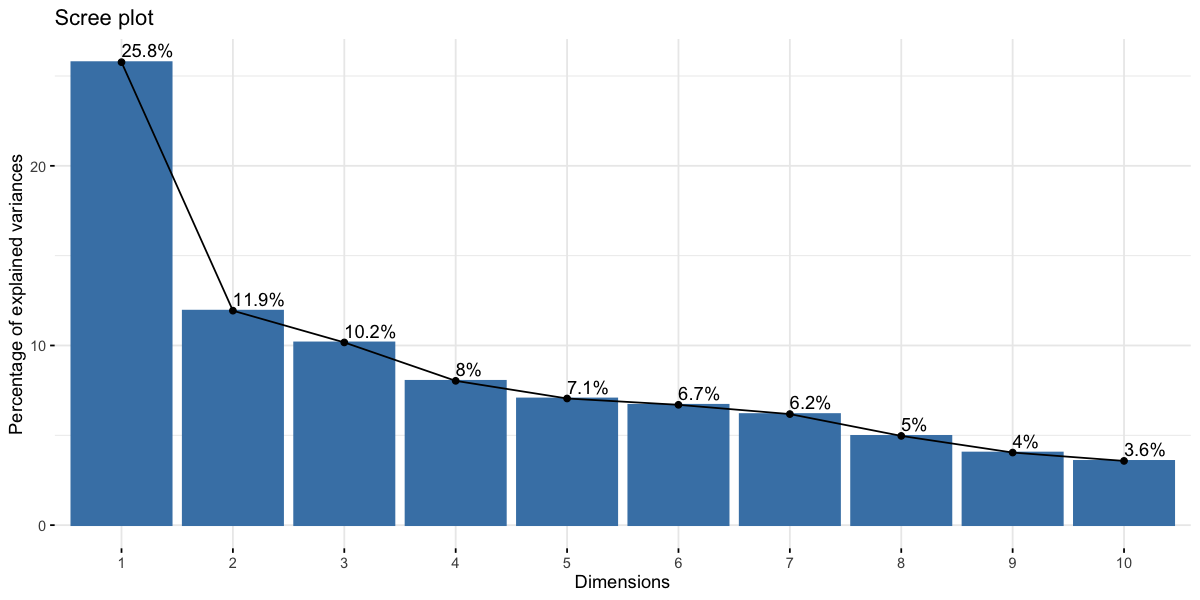

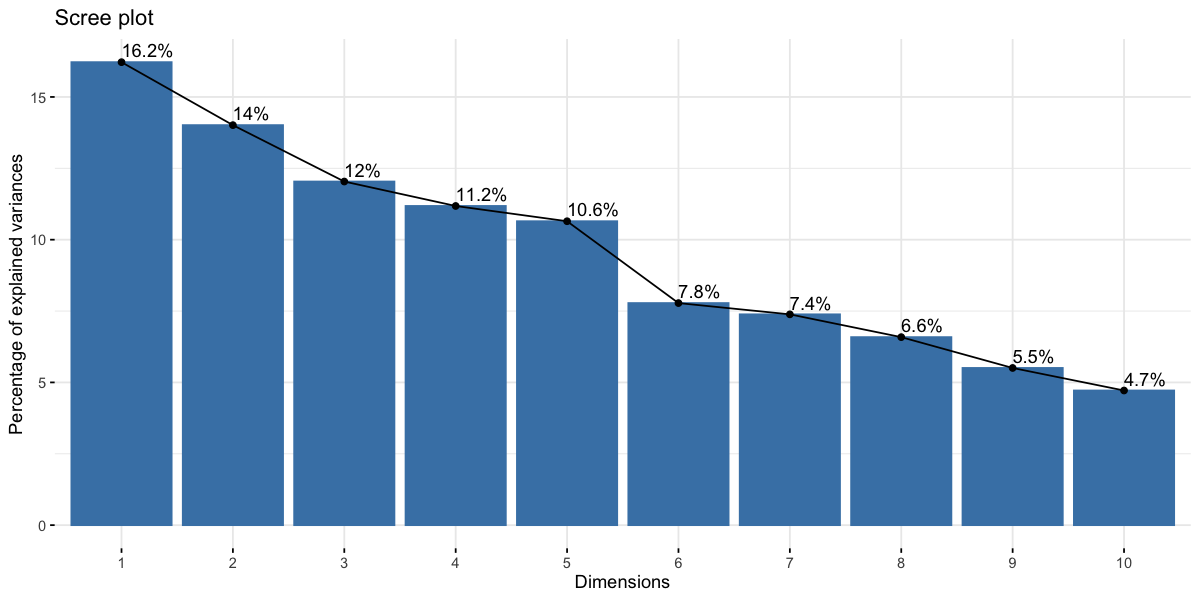

In [21]:
# setting seed for reproducibility
set.seed(12)

pca_saliva_df = combined_saliva_df[,4:ncol(combined_saliva_df)]
pca_stool_df = combined_stool_df[,4:ncol(combined_stool_df)]

# running pca 
saliva_pca = prcomp(pca_saliva_df)
stool_pca = prcomp(pca_stool_df)

# looking at a scree plot to see how much of the variance was captured in the first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(saliva_pca, addlabels = TRUE)
fviz_eig(stool_pca, addlabels = TRUE)